In [346]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from glob import glob
import re

import librosa
import librosa.display
import IPython.display as ipd

In [347]:
TOP_DB = 40
MFCC_SIZE = 39
TEST_SIZE = 0.2

## Read file

In [348]:
audio_files = sorted(glob('./recordings/*'))

In [349]:
import re

text = audio_files[300]
pattern = r'(\d+)_([a-zA-Z]+)_(\d+)\.wav'

result = re.search(pattern, text)
groups = result.groups()
dictionary = {
    'number': int(groups[0]),
    'name': groups[1],
    'order': int(groups[2])
}
dictionary

{'number': 1, 'name': 'george', 'order': 0}

In [350]:
def convert_path_to_dict(path):
    pattern = r'(\d+)_([a-zA-Z]+)_(\d+)\.wav'

    result = re.search(pattern, path)
    groups = result.groups()
    return {
        'number': int(groups[0]),
        'name': groups[1],
        'order': int(groups[2])
    }
convert_path_to_dict(audio_files[300])

{'number': 1, 'name': 'george', 'order': 0}

## MFCC

In [351]:
def analyse_audio(path):
    output = convert_path_to_dict(path)
    y, sr = librosa.load(path)
    y_tr, index = librosa.effects.trim(y, top_db=TOP_DB)
    mfcc = np.array(librosa.feature.mfcc(y=y_tr, sr=sr, n_mfcc=13))
    output['sr'] = sr
    output['y'] = y
    output['y trim'] = y_tr
    output['mfcc'] = mfcc.T
    return output
print([len(i) for i in analyse_audio(audio_files[0])['mfcc']])
print([len(i) for i in analyse_audio(audio_files[1])['mfcc']])
print([len(i) for i in analyse_audio(audio_files[2])['mfcc']])

[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]
[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]
[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]


In [352]:
output_list = [analyse_audio(file) for file in audio_files]
df = pd.DataFrame(output_list)
df[:3]

,number,name,order,sr,y,y trim,mfcc
0,0,george,0,22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-633.7214, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,0,george,1,22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-643.057, 25.02723, 23.553139, 21.222677, 18..."
2,0,george,10,22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-638.5822, -0.03040633, -19.927683, -0.31883..."


Text(0.5, 1.0, 'MFCC')

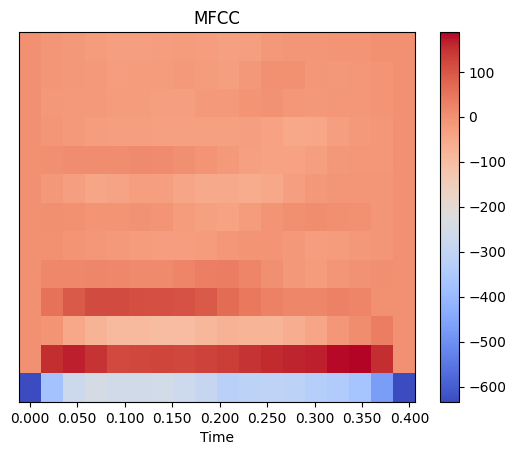

In [353]:
img = librosa.display.specshow(df['mfcc'][0].T, x_axis='time')
plt.colorbar(img)
plt.title('MFCC')

In [354]:
df[df['number'] == 1]['name'].iloc[0]

'george'

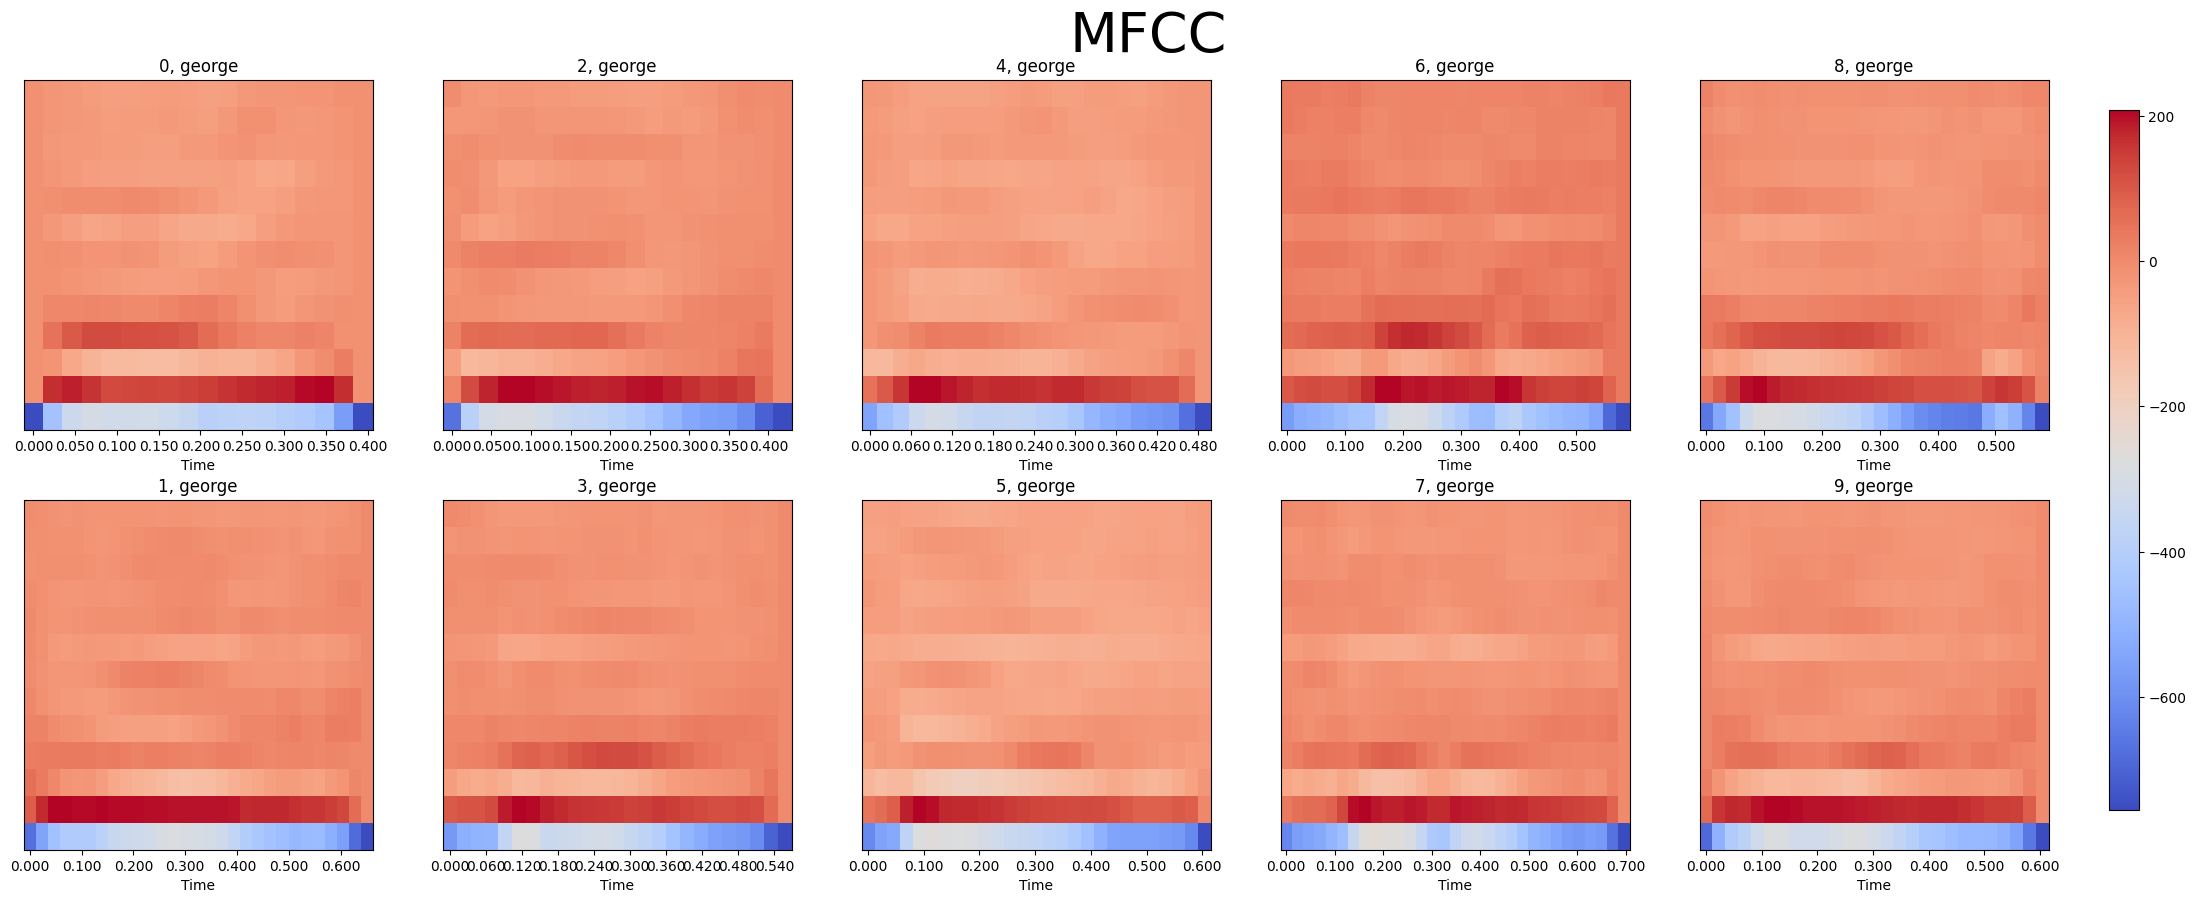

In [355]:
fig, axs = plt.subplots(2, 5, figsize=(30,10))
img=None
for i in range(10):
    img = librosa.display.specshow(df[df['number'] == i]['mfcc'].iloc[0].T, x_axis='time',ax=axs[i%2,i//2])
    axs[i%2,i//2].set_title(f"{i}, {df[df['number'] == i]['name'].iloc[0]}")
fig.suptitle('MFCC',y=0.95,fontsize=40)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.7])
fig.colorbar(img, cax=cbar_ax)

In [356]:
from hmmlearn import hmm

my_hmm = dict()
for i in df['number'].unique():
    hmm_train = hmm.GaussianHMM(n_components=10, covariance_type='diag', n_iter=1000)
    data_len = [len(i) for i in df[df['number'] == i][:-30]['mfcc']]
    data = np.concatenate(np.array(df[df['number'] == i][:-30]['mfcc']))
    hmm_train.fit(data, lengths=data_len)
    my_hmm[i] = hmm_train


In [361]:
# [number][observe] = mfcc
training_data = dict()
testing_data = dict()
for num in df['number'].unique():
    train_tmp = []
    test_tmp = []
    for name in df['name'].unique():
        mini_df = np.array(df[df['number'] == num][df['name'] == name]['mfcc'])
        test_size = int(len(mini_df) * TEST_SIZE)
        train_tmp.append(mini_df[:-test_size])
        test_tmp.append(mini_df[-test_size:])
    training_data[num] = np.concatenate(train_tmp)
    testing_data[num] = np.concatenate(test_tmp)
testing_data[0][0]

/tmp/ipykernel_6248/871133478.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mini_df = np.array(df[df['number'] == num][df['name'] == name]['mfcc'])


array([[-6.29727722e+02,  2.98217945e+01,  2.76949921e+01,
         2.43908043e+01,  2.02328224e+01,  1.56063786e+01,
         1.09050236e+01,  6.47898960e+00,  2.59397173e+00,
        -5.93442082e-01, -3.04065371e+00, -4.80480337e+00,
        -6.01340199e+00],
       [-4.75031555e+02,  1.29698853e+02,  1.61708050e+01,
         3.71414108e+01,  2.89543495e+01,  1.06007290e+01,
        -4.97571278e+00, -2.65481453e+01, -1.40441036e+01,
        -9.27952957e+00, -2.21581573e+01, -2.73422050e+01,
        -1.16736412e+01],
       [-4.01055573e+02,  1.48380310e+02, -1.57750282e+01,
         4.92559738e+01,  2.76501923e+01,  6.95911407e+00,
        -3.77251267e+00, -4.06567535e+01, -2.14234123e+01,
        -1.51829109e+01, -2.55357914e+01, -3.16590614e+01,
        -1.76359711e+01],
       [-3.87555786e+02,  1.34021576e+02, -3.97461662e+01,
         4.98542099e+01,  1.78116074e+01,  3.39264512e-01,
        -4.74210072e+00, -5.05449638e+01, -2.40633698e+01,
        -1.47454853e+01, -2.76817303e

In [371]:
def train_data(data:dict, n_com=3) -> dict:
    hmms = dict()
    for num in data.keys():
        data_len = [len(i) for i in data[num]]
        concatenate_data = np.concatenate(np.array(data[num]))
        new_hmm = hmm.GaussianHMM(n_components=n_com, covariance_type='diag', n_iter=1000)
        new_hmm.fit(concatenate_data, lengths=data_len)
        hmms[num] = new_hmm
    return hmms

In [382]:
def test_hmm(data:dict, hmms:dict) -> dict:
    result = dict()
    for i in data.keys():
        result[i] = []
        for j in data[i]:
            tmp = dict()
            for k in hmms.keys():
                tmp[k] = my_hmm[k].score(j)
            q = max(tmp, key=lambda k: tmp[k])
            result[i].append(q)
    return result

In [ ]:
def create_test_and_train_data(df, par_main, par_side, test_percent=TEST_SIZE):
    '''[par_main][par_side] = mfcc'''
    training_data = dict()
    testing_data = dict()
    for i in df[par_main].unique():
        train_tmp = []
        test_tmp = []
        for j in df[par_side].unique():
            filtered_data = np.array(df[df[par_main] == i][df[par_side] == j]['mfcc'])
            test_size = int(len(filtered_data) * TEST_SIZE)
            train_tmp.append(filtered_data[:-test_size])
            test_tmp.append(filtered_data[-test_size:])
        training_data[i] = np.concatenate(train_tmp)
        testing_data[i] = np.concatenate(test_tmp)
    return training_data, testing_data

In [418]:
def visual_result(result):
    result_present = {i:
        {j:
            int(result[i].count(j)/len(result[i])*100)
            for j in result.keys()} 
        for i in result.keys()}
    a = pd.DataFrame(out)
    ax = sns.heatmap(a, annot=True, linewidth=0.5, fmt='0')
    ax.set(xlabel="label", ylabel="result")
    ax.invert_yaxis()

In [373]:
# [number][observe] = mfcc
training_data, training_data=create_test_and_train_data(df, 'number', 'name')
hmms = train_data(training_data, n_com=10)
result = test_hmm(testing_data,hmms)
visual_result(result)

/tmp/ipykernel_6248/2622911166.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mini_df = np.array(df[df['number'] == num][df['name'] == name]['mfcc'])


TypeError: 'dict' object is not callable

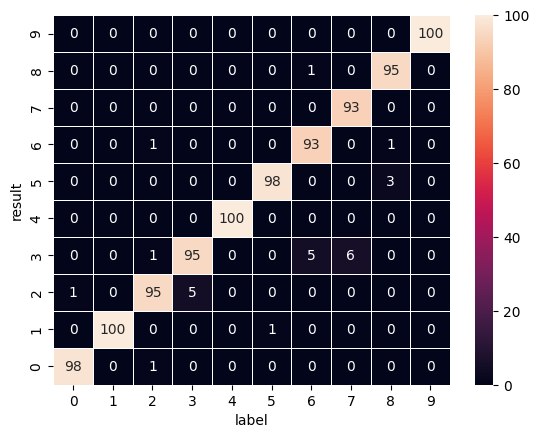

In [419]:
result = test_hmm(testing_data,hmms)
visual_result(result)

In [358]:
my_hmm = dict()
for num in df['number'].unique():
    data_len = [len(i) for i in training_data[num]]
    data = np.concatenate(np.array(training_data[num]))
    hmm_train = hmm.GaussianHMM(n_components=10, covariance_type='diag', n_iter=1000)
    hmm_train.fit(data, lengths=data_len)
    my_hmm[num] = hmm_train

In [ ]:
result = dict()
for i in df['number'].unique():
    result[i] = []
    for j in testing_data[i]:
        tmp = dict()
        for k in df['number'].unique():
            tmp[k] = my_hmm[k].score(j)
        q = max(tmp, key=lambda k: tmp[k])
        result[i].append(q)
a = pd.DataFrame(result)
a

In [386]:
c = {}
for i in df['number'].unique():
    c[i] = (30 - len(a[a[i] != i]))/30
pd.Series(c)

0    0.966667
1    1.000000
2    0.900000
3    0.900000
4    1.000000
5    0.966667
6    0.866667
7    0.866667
8    0.900000
9    1.000000
dtype: float64